# Exercise 04: Random Graphs and Small-World Networks

**Assignment due:** *March 19 2019*

In this week's assignment, we explore some of the models for random graphs and small-world networks that we have introduced in the last lecture. We specifically study how diameter, clustering coefficient, and degree distribution of random graphs are related to the parameters of the $G(n,p)$ model. We further implement the Watts-Strogatz model and explore how its parameters influence those characteristics that are associated with the small-world property of complex networks.

In [1]:
#BOILERPLATECODE

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm

import multiprocessing
from joblib import Parallel, delayed

NUM_CORES = multiprocessing.cpu_count()

Check that you have the right versions of `pathpy` and `networkx` installed.

In [2]:
assert nx.__version__=='2.2'

In [3]:
import pathpy as pp
assert pp.__version__=='2.2.0'

In [4]:
def random_color():
    return [list(np.random.random(3))]

## Task 1: Erdös-Rényi networks

### 1.1 The G(n,p) model

Implement a python function that generates a random graph according to the G(n,p) model for undirected networks as introduced in the lectures. Test your function by generating (and visualising) five microstates generated for the same parameters $n$ and $p$.

In [5]:
# For nice visualization use "netwulf"
for i in range(5):
    fig = plt.figure()
    g = nx.gnp_random_graph(n=10, p=.1)
    nx.draw(g, node_color=random_color())
    plt.savefig('./graphics/exercise_04_task_1_1_graph_{}.png'.format(i))
    fig.clf()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

### 1.2 Diameter in Random Graphs

For $20$ uniformly spaced points $n$ in the interval $[100,2000]$ and a fixed mean degree $np=4$, compute the diameter $diam(n)$ of the largest connected components of microstates generated by the $G(n,p)$ model. Plot the empirical diameter $diam(n)$  (y-axis) against the number of nodes $n$ (x-axis) and compare the scaling behavior to the analytical result from lecture L04, slide 11.

In [6]:
#BOILERPLATECODE
def average_diameter(mean_degree, n, samples=1):
    diam = 0.
    for i in range(samples):
        # for large spare networkx use nx.fast_gnp_random_graph(n, p)
        g = nx.fast_gnp_random_graph(n=n, p=mean_degree/n)
        # This gives the diameter of the largest connected component
        diam += nx.diameter(max(nx.connected_component_subgraphs(g), key=len))
    return diam/samples


def plot_diameter(mean_degree, n_range, samples=1):
    plt.clf()
    fig = plt.figure()
    ax = plt.subplot(111)
    diams = Parallel(n_jobs=NUM_CORES)(delayed(average_diameter)(mean_degree, n, samples) for n in n_range)
    plt.plot(n_range, diams)
    plt.xlabel(r'Network size $n$')
    plt.ylabel(r'Diameter $D$')     
    plt.tight_layout()
    plt.savefig('./graphics/exercise_04_task_1_2_diameter.png')
    plt.show();

**Additive:** Generate a random vector of size $n ( n - 1 ) / 2$. Generate a boolean vector on the condition $<p$. Then iterate over the elements.

<Figure size 432x288 with 0 Axes>

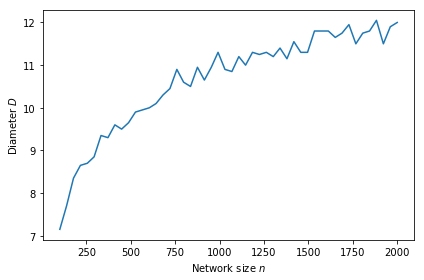

In [7]:
n_range = np.linspace(100, 2000, 50, dtype=int)
plot_diameter(4, n_range, 20)

Why does the diameter $D$ alternate?

### 1.3 Clustering coefficient in the G(n,p) model

For $50$ uniformly spaced points $p$ in the interval $[0,0.15]$, create microstates of the $G(n,p)$ model with $n=200$ and compute the global clustering coefficient $C$ of the microstates. For each point $p$ generate $20$ microstates and average the global clustering coefficients of these individual microstates. Plot the average values of $C$ (y-axis) against $p$ (x-axis) and interpret your results in light of the results from lecture L04, slide 09.

In [8]:
#BOILERPLATECODE
def average_clustering_coeff(n, p, samples=1):
    cc = 0
    for i in range(samples):
        g = nx.fast_gnp_random_graph(n, p)
        cc += nx.algorithms.cluster.average_clustering(g)
    return cc/samples


def plot_clustering_coeff(n, p_range, samples=1):
    ccs = Parallel(n_jobs=NUM_CORES)(delayed(average_clustering_coeff)(n, p, samples) for p in p_range)
            
    plt.clf()
    x = plt.plot(p_range,ccs)
    plt.xlabel(r'Probability $p$')
    plt.ylabel(r'Global clustering $C$')     
    plt.tight_layout(pad=.5)
    plt.savefig('./graphics/exercise_04_task_1_3_clustering.png')
    plt.show();

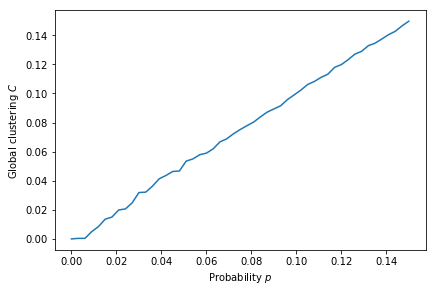

In [9]:
p_range = np.linspace(0, 0.15, 51)
plot_clustering_coeff(200, p_range, 20)

Repeat the experiment from above for a fixed value of $np=4$ and $20$ uniformly spaced points $n$ in the interval $[100,2000]$. For this, you should adapt the functions from above accordingly. Again, plot the average values of $C$ (y-axis) against $n$ (x-axis) and interpret your results.

In [10]:
def plot_cluster_coeff_number_of_nodes(n_values, np, samples=1):
    ccs = Parallel(n_jobs=NUM_CORES)(delayed(average_clustering_coeff)(n, np/n, samples) for n in n_values)
            
    plt.clf()
    plt.plot(n_values, ccs)
    plt.xlabel(r'Number of nodes $n$')
    plt.ylabel(r'Global clustering $C$')
    plt.xscale('log')
    plt.yscale('log')
    plt.savefig('./graphics/exercise_04_task_1_3_clustering_2.png')
    plt.show();

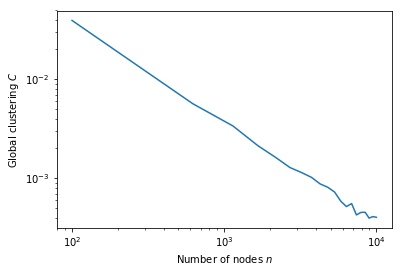

In [11]:
mean_degree = 4.
n_values = np.linspace(100, 10000, 20, dtype=int)

plot_cluster_coeff_number_of_nodes(n_values, mean_degree, 20)

Why does the variance increase with increasing number of nodes $n$?

### 1.4 Poisson vs. Normal approximation of degree distributions

Use your implementation of the $G(n,p)$ model to generate random networks with $n=1000$ nodes for values of the parameter $p$ corresponding to different mean degrees $\langle k \rangle = 2$, $\langle k \rangle = 5$, $\langle k \rangle = 20$, and $\langle k \rangle =50$. Compute and plot the degree distributions of the generated microstates and interpret their shape.

In [12]:
def plot_degree_distribution(n, np_values):
    plt.clf();
    
    for np in np_values:
        g = nx.fast_gnp_random_graph(n, np/n)
        degree_distr = nx.degree_histogram(g)
        plt.plot(
            degree_distr,
            '.',
            label=r'{}'.format(np)
        )
        
    plt.legend(loc='best', title=r'$np$')
    plt.xlabel(r'Degree $d$')
    plt.ylabel(r'Probability $p$')     
    plt.tight_layout()
    plt.savefig('./graphics/exercise_04_task_1_4_degree_distribution.png')
    plt.show();

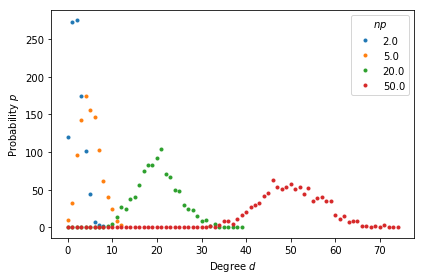

In [13]:
mean_degree_values = [2., 5., 20., 50.]
n = 1000

plot_degree_distribution(n, mean_degree_values)

Use the `fit` function in the class `scipy.stats.norm` to calculate the "most likely" parameters of the Normal distribution for the resulting degree distributions.

In [14]:
def calculate_degree_distribution_parameters(n, np_values):  
    print('np \t mean \t index of dispersion')
    for np in np_values:
        g = nx.fast_gnp_random_graph(n, np/n)
        degree_values = [val for key, val in g.degree]
        fit_values = norm.fit(degree_values)
        print('{:d}\t{:4.2f}\t{:4.2f}'.format(int(np), fit_values[0], fit_values[1]))

In [15]:
calculate_degree_distribution_parameters(n, mean_degree_values)

np 	 mean 	 index of dispersion
2	1.94	1.39
5	5.07	2.27
20	19.74	4.47
50	49.39	6.66


## Task 2: Small-world networks

### 2.1 The Watts-Strogatz model

Implement the Watts-Strogatz model for a dimensionality of $d=1$, i.e. for the initial case of a ring-lattice as presented in lecture L04, slide 23. Generate and plot random realisations with $n=100$ nodes and rewiring probabilities of $p=0$, $p=0.04$ and $p=1$.

In [16]:
# TODO continue here
def WattsStrogatz(n, s, p):
    nodes = np.arange(n)
    g = nx.Graph()
    g.add_nodes_from(nodes)
    for i in np.arange(1, s+1):
        g.add_edges_from(list(zip(np.append(nodes[i:], nodes[:i]),nodes)))
        
    for i in np.arange(1, s+1):
        for u, v in zip(np.append(nodes[i:], nodes[:i]),nodes):
            if np.random.random() < p:
                w = np.random.randint(n)
                while u == w or g.has_edge(u, w):
                    w = np.random.choice(nodes)
                if g.degree(u) >= n-1:
                    break
                else:
                    g.remove_edge(u,v)
                    g.add_edge(u, w) 
    return g

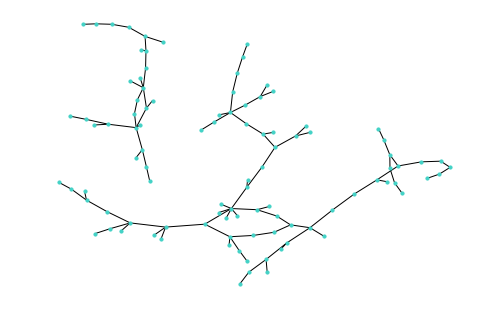

In [17]:
p_values = [0., .04, 1.]

for pInd, pVal in enumerate(p_values):
    plt.clf()
    g = WattsStrogatz(100, 1, pVal)
    nx.draw(g, node_size=10, node_color=random_color())
    plt.savefig('./graphics/exercise_04_task_2_1_graph_{}.png'.format(pVal))

### 2.2 The small-world regime of the Watts-Strogatz model

Use your implementation to generate a number of realisations for a fixed value of $n=100$ and a number of logarithmically-spaced values of the rewiring parameter $p$. For each value of $p$ generate 20 samples and calculate the ___average shortest path___ length and the ___average global clustering coefficient___ across these samples. For the average shortest path length, you can use the function `avg_path_length` in the `pathpy` module `algorithms.shortest_paths`. For the global clustering coefficient you can reuse the function from the previous week (included below).

In [18]:
#BOILERPLATECODE

# def local_cc(network, v):
#     if network.nodes[v]['degree']<2:
#         return 1
#     k_i = 0
#     for i in network.successors[v]:
#         for j in network.successors[v]:
#             if (i,j) in network.edges:
#                 k_i += 1    
#     return k_i/(network.nodes[v]['degree']*(network.nodes[v]['degree']-1))

# def global_cc(network):
#     s = 0
#     for v in network.nodes:
#         s += local_cc(network, v)
#     return s/network.ncount()

In [19]:
# n = 100, logarithmic spaced p, sample_size = 20
# ---> average shortest path length and average globabl clustering

def avg_shortest_path(n, p, s=1, samples=1):
    asp = 0.
    k = 2 * s
    for s in range(samples):
        g = nx.watts_strogatz_graph(n=n, k=k, p=p)
        # take the largest connected component
        asp += nx.average_shortest_path_length(max(nx.connected_component_subgraphs(g), key=len))

    return asp / samples

def avg_gcc(n, p, s, samples=1):
    agcc = 0.
    k = 2 * s
    for s in range(samples):
        g = nx.watts_strogatz_graph(n=n, k=k, p=p)
        agcc += nx.algorithms.average_clustering(g)
        
    return agcc / samples

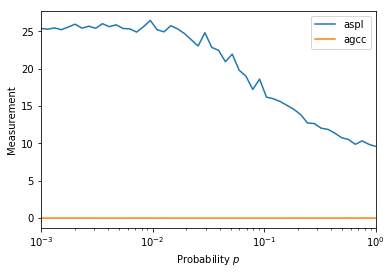

In [20]:
p_values = np.logspace(-3, 0)
network_size = 100
sample_size = 50
initial_s = 1

average_shortest_path_lengths = Parallel(n_jobs=NUM_CORES)(delayed(avg_shortest_path)(network_size, p, initial_s, sample_size) for p in p_values)
average_global_clustering_coeffs = Parallel(n_jobs=NUM_CORES)(delayed(avg_gcc)(network_size, p, initial_s, sample_size) for p in p_values)

plt.clf()
plt.plot(p_values, average_shortest_path_lengths, label='aspl')
plt.plot(p_values, average_global_clustering_coeffs, label='agcc')
plt.legend()
plt.xlim(min(p_values), max(p_values))
plt.xlabel(r'Probability $p$')
plt.ylabel(r'Measurement')
plt.xscale('log')
# plt.yscale('log')
plt.savefig('./graphics/exercise_04_task_2_2_measurements_s_{}.png'.format(initial_s))
plt.show()

Plot the average shortest path length and the average clustering coefficient (both on the y-axis) against the rewiring probability $p$ (use a log-scale for the x-axis). What do you observe?

### Answer
The __average shortest path length__ increases with increasing rewiring probablity $p$. As we are only connected to the nearest neighbor in the begin of the construction of the Watts-Strogatz graph, the __average global clustering coefficient__ stays zero or close to zero. If we connect the nodes also the the next-nearest neighbor or more on the ring, the average globabl cluster coefficient decreases from a non-zero values to zero with increasing rewiring probability $p \rightarrow 1$.

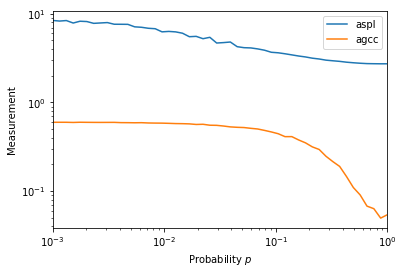

In [21]:
p_values = np.logspace(-3, 0)
network_size = 100
sample_size = 20
initial_s = 3

average_shortest_path_lengths = Parallel(n_jobs=NUM_CORES)(delayed(avg_shortest_path)(network_size, p, initial_s, sample_size) for p in p_values)
average_global_clustering_coeffs = Parallel(n_jobs=NUM_CORES)(delayed(avg_gcc)(network_size, p, initial_s, sample_size) for p in p_values)

plt.clf()
plt.plot(p_values, average_shortest_path_lengths, label='aspl')
plt.plot(p_values, average_global_clustering_coeffs, label='agcc')
plt.legend()
plt.xlim(min(p_values), max(p_values))
plt.xlabel(r'Probability $p$')
plt.ylabel(r'Measurement')
plt.xscale('log')
plt.yscale('log')
plt.savefig('./graphics/exercise_04_task_2_2_measurements_s_{}.png'.format(initial_s))
plt.show()